# All Data - NLP EDA - NER on Company Names

This file doesn't run the NER, but does the plotting only

In [1]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
from stattotex import *

In [2]:
# Set output folder
output_folder = '../../../Output/All Data EDA/NLP EDA - NER on Company Names/'

In [3]:
# Load dataframe
# '../../../Data/Company_Mentions/Company_Mentions.parquet'
df = pd.read_parquet('../../../Data/Company_Mentions/Company_Mentions.parquet')
df

,ticker,fixed_quarter_date,company_mentions
0,NEE,2011-04-01 00:00:00.000000,179
1,NEE,2011-07-01 00:00:00.000000,107
2,NEE,2011-10-01 00:00:00.000000,123
3,NEE,2012-01-01 00:00:00.000000,170
4,NEE,2012-04-01 00:00:00.000000,154
...,...,...,...
912,KOP,2015-04-01 00:00:00.000000,104
913,KOP,2015-07-01 00:00:00.000000,59
914,KOP,2015-10-01 00:00:00.000000,58
915,KOP,2016-01-01 00:00:00.000000,73


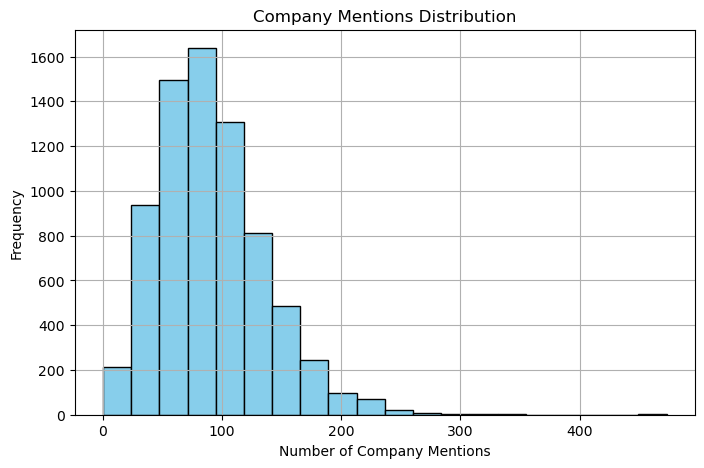

Average number of company mentions: 90.92637032997


In [4]:
# Plot the distribution of company mentions
plt.figure(figsize=(8, 5))
plt.hist(df['company_mentions'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Company Mentions')
plt.ylabel('Frequency')
plt.grid(True)
# Output version with no title
plt.savefig(output_folder + 'Company Mentions Distribution No Title.png')
plt.title('Company Mentions Distribution')
plt.show()

print('Average number of company mentions:', df['company_mentions'].mean())

stattotex(round(df['company_mentions'].mean(), 2), 'avg_company_mentions', output_folder + 'Company Mentions Average.tex')